## Мобильные приложения — Выделение групп пользователей на основе поведения

Выделить различающиеся по продуктовым метрикам группы пользователей на основе событий, которые они выполняют в мобильном приложении.

- Провести исследовательский анализ данных
- Сегментировать пользователей на основе событий
- Проверить статистические гипотезы

    *Проверить гипотезу различия конверсии в просмотры контактов между теми пользователями, которые совершили установку приложения, прийдя с источника `yandex` и пользователя, совершившими установки, из источника `google`*

    *Сформулировать и проверить статистическую гипотезу относительно представленных данных*

### **Описание данных:**

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет **mobile_dataset.csv** содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

## План работы над проектом

#### Предварительный анализ данных
- Провести предобработку данных.
- Провести исследовательский анализ данных.
- Провести расчет новых признаков - продуктовых метрик для каждого клиента:
    - retention rate
    - время в приложении
    - частота совершения событий 
    - конверсия в целевое действие `contacts_show`
- EDA. Провести анализ качества признаков (отсутствующие признаки, средние значения и стандартные отклонения).
- EDA. Сформулировать предварительные гипотезы на основе результата анализа признаков (построение столбчатых гистограмм и распределения признаков, построение матрицы корреляции для признаков).
- Провести стандартизацию данных.
#### Выделение групп пользователей
- Построенить матрицу расстояний на стандартизованной матрице признаков и отрисовать дендрограмму
- Определить числа кластеров на основе дендрограммы.
- Выбрать и обучить модель кластеризации, спрогнозировать кластеров клиентов.
- Проанализироавть средних значений признаков для кластеров.
- Проанализироавть распределения признаков по кластерам.
- Проанализироавть распределения целевой переменной по кластерам.
#### Подведение итогов и представление результатов. 
- Сформулировать выводы о поведении пользователей из разных групп.
- Построить дашборд в Tableau
#### Проверка статистических гипотез
- Проверить гипотезу различия конверсии в просмотры контактов между теми пользователями, которые совершили установку приложения, прийдя с источника yandex и пользователя, совершившими установки, из источника google

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math as mth
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from matplotlib import pyplot
from matplotlib import rcParams

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Предварительный анализ данных

### Предобработка данных

In [3]:
events = pd.read_csv('mobile_dataset.csv')
users = pd.read_csv('mobile_soures.csv')
events.head(3)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
event.time    74197 non-null object
event.name    74197 non-null object
user.id       74197 non-null object
dtypes: object(3)
memory usage: 1.7+ MB


##### в таблице   событий пропусков нет, дубликатов нет. Столбец с временем события нужно преобразовать к типу datetime. Имена столбцов в обеих таблицах приведем к привычному виду - только строчные буквы и подчеркивания вместо точек

In [5]:
events = events.rename(columns={'event.time':'event_time','event.name':'event_name', 'user.id':'user_id'})
events['event_time'] = events['event_time'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

In [6]:
# выделим день, час и неделю в отдельные столбцы
#events['event_hour'] = events['event_time'].time()
events['event_hour'] = events['event_time'].dt.hour
events['event_day'] = events['event_time'].astype('datetime64[D]')
events['week'] = events['event_time'].dt.week

events.head(3)

,event_time,event_name,user_id,event_hour,event_day,week
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,0,2019-10-07,41
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,0,2019-10-07,41
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,0,2019-10-07,41


In [7]:
users.duplicated().sum()

0

In [8]:
users = users.rename(columns={'userId':'user_id'})
users.head(3)

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex


##### В таблице с пользователями также нет пропусков и дубликатов

### Исследовательский анализ данных

In [9]:
# общее количество пользователей
users['user_id'].nunique()

4293

In [10]:
#Какие есть источники пользователей и сколько они нам приносят?
users.groupby('source').count().sort_values('user_id', ascending=False)

,user_id
source,
yandex,1934
other,1230
google,1129


##### Яндекс впереди на 50% по сравнению с гуглом и всеми остальными и принес 45% пользователей из всех.

In [11]:
#Количество разных событий 
events.groupby('event_name').count().sort_values('user_id', ascending=False)

,event_time,user_id,event_hour,event_day,week
event_name,,,,,
tips_show,40055,40055,40055,40055,40055
photos_show,10012,10012,10012,10012,10012
advert_open,6164,6164,6164,6164,6164
contacts_show,4450,4450,4450,4450,4450
map,3881,3881,3881,3881,3881
search_1,3506,3506,3506,3506,3506
favorites_add,1417,1417,1417,1417,1417
search_5,1049,1049,1049,1049,1049
tips_click,814,814,814,814,814


In [12]:
# из условий задания знаем, что show_contacts это то же самое, что и contacts_show. Переприсвоим.
events.loc[events['event_name']=='show_contacts', 'event_name'] = 'contacts_show'

In [13]:
events.groupby('event_name').count().sort_values('user_id', ascending=False)

,event_time,user_id,event_hour,event_day,week
event_name,,,,,
tips_show,40055,40055,40055,40055,40055
photos_show,10012,10012,10012,10012,10012
advert_open,6164,6164,6164,6164,6164
contacts_show,4529,4529,4529,4529,4529
map,3881,3881,3881,3881,3881
search_1,3506,3506,3506,3506,3506
favorites_add,1417,1417,1417,1417,1417
search_5,1049,1049,1049,1049,1049
tips_click,814,814,814,814,814


In [14]:
# Объединим таблицы по столбцу user_id
users_events = pd.merge(users, events, on='user_id')
users_events.head(3)

,user_id,source,event_time,event_name,event_hour,event_day,week
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00.431357,advert_open,0,2019-10-07,41
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01.236320,tips_show,0,2019-10-07,41
2,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07.039334,tips_show,0,2019-10-07,41


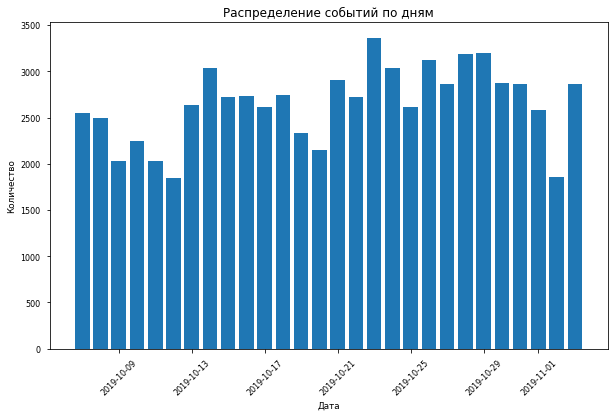

In [15]:
# распределение событий по дням
events_by_day = users_events.groupby('event_day', as_index=False).agg({'user_id':'count'})

plt.figure(figsize=(10,6))
with plt.style.context('seaborn-paper'):
    plt.bar(events_by_day['event_day'], events_by_day['user_id'])
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.title('Распределение событий по дням')
plt.xticks(rotation=45)     
plt.show()

Массив данных событий распределен по времени с 07.10 по 03.11 2019 года. Практически на всем протяжении периода наблюдений наблюдается тенденция к росту количества событий в сутки (с примерно 2500 до 3200). При этом есть регулярные провалы в выходные дни - пятницы, субботы, воскресенья, что логично. Человек слаб, любит продать или купить что-нибудь в рабочее время.

In [16]:
# можем посчитать конверсию для пользователей
users_events.query('event_name=="contacts_show"')['user_id'].nunique() / users['user_id'].nunique()

0.22851153039832284

### Конверсия для всего массива данных = 0,23

### Расчет новых признаков - продуктовых метрик для каждого клиента

#### Посчитаем время, проведенное в приложении и частоту визитов

In [17]:
# выделяем начало и конец каждого сеанса в приложении
user_time_min = users_events.groupby(['user_id', 'event_day', 'event_hour'], as_index=False).agg({'event_time':'min'})
user_time_min = user_time_min.rename(columns={'event_time':'event_time_start'})

user_time_max = users_events.groupby(['user_id', 'event_day', 'event_hour'], as_index=False).agg({'event_time':'max'})
user_time_max = user_time_max.rename(columns={'event_time':'event_time_stop'})

In [18]:
# склеиваем стобцы времени начала и конца сеансов и вычитаем одно из другого
user_time =  pd.merge(user_time_min, user_time_max, on=['user_id', 'event_day', 'event_hour'])
user_time['spent_time'] = user_time['event_time_stop'] - user_time['event_time_start']
user_time.head(3)

,user_id,event_day,event_hour,event_time_start,event_time_stop,spent_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,13,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,00:09:55.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,18,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,00:08:27.385985
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,19,2019-10-21 19:52:30.778932,2019-10-21 19:57:49.029206,00:05:18.250274


In [19]:
# начнем формировать таблицу с признаками для будущей кластеризации - считаем общее время и число сессий
features = user_time.groupby('user_id', as_index=False).agg({'spent_time':'sum','event_day':'count'}).rename(columns={'event_day':'visits'})

features.head(3)

,user_id,spent_time,visits
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,00:43:49.147390,5
1,00157779-810c-4498-9e05-a1e9e3cedf93,02:57:40.663278,10
2,00463033-5717-4bf1-91b4-09183923b9df,00:21:14.554274,2


#### Считаем количество целевых действий для всех пользователей

In [20]:
# пользователи, совершившие целевое действие (и сколько раз)
conversion = users_events.query('event_name=="contacts_show"').groupby('user_id', as_index=False).agg({'event_name':'count'})
conversion = conversion.rename(columns={'event_name':'conversions'})
conversion.head(3)

,user_id,conversions
0,00157779-810c-4498-9e05-a1e9e3cedf93,11
1,00551e79-152e-4441-9cf7-565d7eb04090,3
2,005fbea5-2678-406f-88a6-fbe9787e2268,3


In [21]:
# добавляем этот столбец в таблицу признаков
features = pd.merge(features, conversion, on=['user_id', ], how='left')
features.head(3)

,user_id,spent_time,visits,conversions
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,00:43:49.147390,5,NaN
1,00157779-810c-4498-9e05-a1e9e3cedf93,02:57:40.663278,10,11.0
2,00463033-5717-4bf1-91b4-09183923b9df,00:21:14.554274,2,NaN


In [22]:
# заменяем NaN-ы нулями
features['conversions'] = features['conversions'].fillna(0)
features.head(3)

,user_id,spent_time,visits,conversions
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,00:43:49.147390,5,0.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,02:57:40.663278,10,11.0
2,00463033-5717-4bf1-91b4-09183923b9df,00:21:14.554274,2,0.0


##### Признак "Пользователи, просмотревшие рекомендованные (tip_click) и добавившие в избранное (favorites_add)", как показатель вовлеченности в использование приложения

In [23]:
tips = users_events.query('event_name=="tips_click"').groupby('user_id', as_index=False).agg({'event_name':'count'})
tips = tips.rename(columns={'event_name':'tips'})
#tips

In [24]:
features = pd.merge(features, tips, on=['user_id', ], how='left')
features['tips'] = features['tips'].fillna(0)

In [25]:
favs = users_events.query('event_name=="favorites_add"').groupby('user_id', as_index=False).agg({'event_name':'count'})
favs = favs.rename(columns={'event_name':'favs'})

In [26]:
features = pd.merge(features, favs, on=['user_id', ], how='left')
features['favs'] = features['favs'].fillna(0)

#### Общее время использования приложения

In [27]:
# выделяем начало и конец каждого сеанса в приложении
user_start_time = users_events.groupby(['user_id'], as_index=False).agg({'event_time':'min'})
user_start_time = user_start_time.rename(columns={'event_time':'user_start_time'})

user_stop_time = users_events.groupby(['user_id'], as_index=False).agg({'event_time':'max'})
user_stop_time = user_stop_time.rename(columns={'event_time':'user_stop_time'})

In [28]:
# склеиваем стобцы времени начала и конца сеансов и вычитаем одно из другого
total_user_time =  pd.merge(user_start_time, user_stop_time, on=['user_id'])
total_user_time['total_time_spent'] = total_user_time['user_stop_time'] - total_user_time['user_start_time']
total_user_time = total_user_time.drop(['user_start_time', 'user_stop_time'], axis=1)
total_user_time['total_time_spent'] = total_user_time['total_time_spent'].astype('timedelta64[s]') / 60
total_user_time.head(3)

,user_id,total_time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,21471.100000
1,00157779-810c-4498-9e05-a1e9e3cedf93,21337.583333
2,00463033-5717-4bf1-91b4-09183923b9df,24.700000


In [29]:
features = pd.merge(features, total_user_time, on=['user_id', ], how='left')
features.head()

,user_id,spent_time,visits,conversions,tips,favs,total_time_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,00:43:49.147390,5,0.0,0.0,0.0,21471.100000
1,00157779-810c-4498-9e05-a1e9e3cedf93,02:57:40.663278,10,11.0,0.0,2.0,21337.583333
2,00463033-5717-4bf1-91b4-09183923b9df,00:21:14.554274,2,0.0,0.0,0.0,24.700000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,01:27:33.169168,7,0.0,0.0,0.0,18688.166667
4,00551e79-152e-4441-9cf7-565d7eb04090,00:09:19.664543,3,3.0,0.0,0.0,4892.516667


### EDA. Анализ качества признаков (отсутствующие признаки, средние значения и стандартные отклонения).

In [30]:
features.describe()

,spent_time,visits,conversions,tips,favs,total_time_spent
count,4293,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,0 days 00:28:49.653642,2.895877,1.054973,0.189611,0.330072,3794.306988
std,0 days 00:58:14.005422,4.230995,4.989622,1.044630,2.109938,7479.109498
min,0 days 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0 days 00:05:34.637738,1.000000,0.000000,0.000000,0.000000,9.766667
50%,0 days 00:13:31.864715,2.000000,0.000000,0.000000,0.000000,42.533333
75%,0 days 00:30:52.278686,3.000000,0.000000,0.000000,0.000000,3843.750000
max,1 days 02:33:35.763801,113.000000,137.000000,30.000000,63.000000,38685.400000


Все признаки у нас числовые. Бросаются в глаза очень большие максимальные значения относительно средних и медиан. Очень похоже на выбросы, которые стоит почистить.

### EDA. Формулировка предварительных гипотез на основе результата анализа признаков (построение столбчатых гистограмм и распределения признаков, построение матрицы корреляции для признаков).

conversions
[ 2.  5. 15.]
favs
[0. 1. 9.]
tips
[0. 1. 4.]
visits
[ 5.  8. 19.]


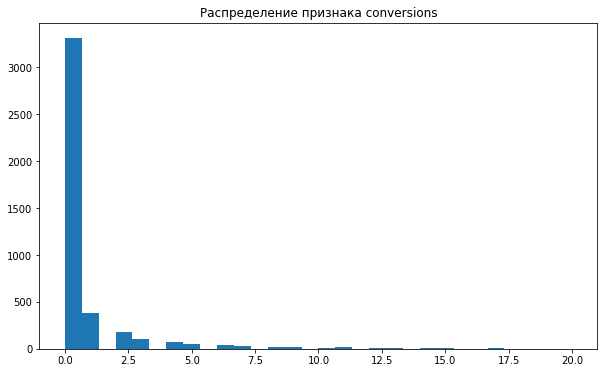

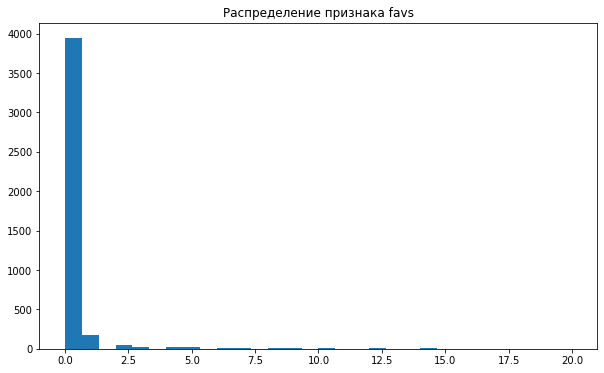

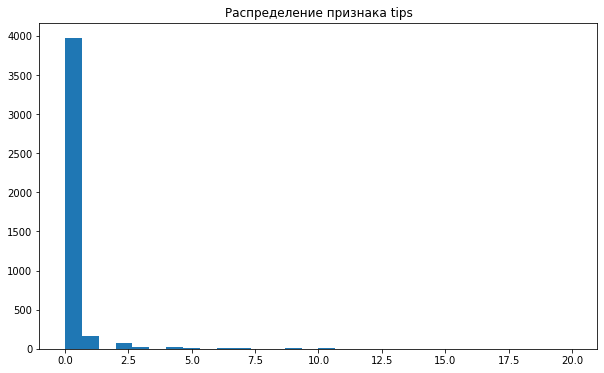

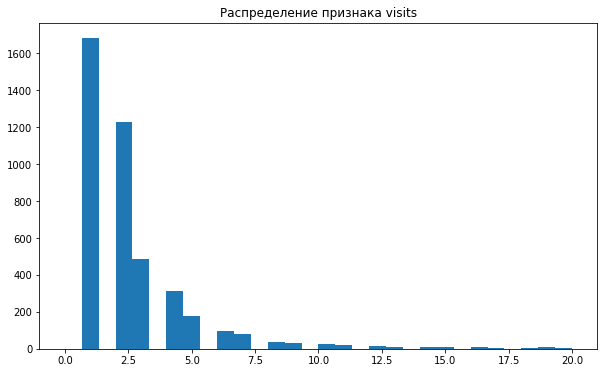

In [31]:
for i in {'visits', 'conversions', 'tips', 'favs'}:
    print(i)
    print(np.percentile(features[i], [90, 95, 99]))
    str = 'Распределение признака '+ i
    plt.figure(figsize=(10,6))
    plt.title(str)
    plt.hist(features[i], bins=30, range=(0,20));
    

In [32]:
np.percentile(features['visits'], [90, 95, 99])

array([ 5.,  8., 19.])

In [33]:
np.percentile(features['conversions'], [90, 95, 99])

array([ 2.,  5., 15.])

In [34]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4293 entries, 0 to 4292
Data columns (total 7 columns):
user_id             4293 non-null object
spent_time          4293 non-null timedelta64[ns]
visits              4293 non-null int64
conversions         4293 non-null float64
tips                4293 non-null float64
favs                4293 non-null float64
total_time_spent    4293 non-null float64
dtypes: float64(4), int64(1), object(1), timedelta64[ns](1)
memory usage: 268.3+ KB


In [35]:
features['time_spent'] = features['spent_time'].astype('timedelta64[s]') / 60

In [36]:
features = features.drop(['spent_time'], axis=1)

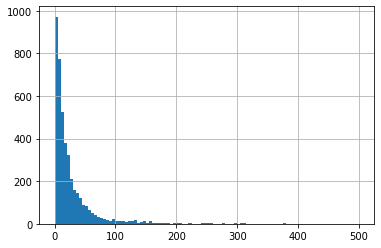

In [37]:
features['time_spent'].hist(bins=100, range=(0, 500));

In [38]:
np.percentile(features['time_spent'], [90, 95, 99])

array([ 62.19666667, 102.31666667, 241.196     ])

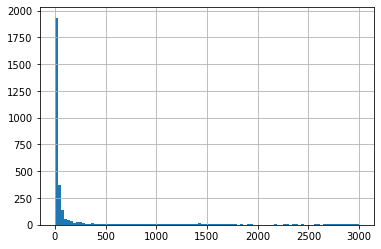

In [39]:
features['total_time_spent'].hist(bins=100, range=(0, 3000));

In [40]:
np.percentile(features['total_time_spent'], [90, 95, 99])

array([14115.00333333, 21850.21666667, 33106.26333333])

In [41]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4293 entries, 0 to 4292
Data columns (total 7 columns):
user_id             4293 non-null object
visits              4293 non-null int64
conversions         4293 non-null float64
tips                4293 non-null float64
favs                4293 non-null float64
total_time_spent    4293 non-null float64
time_spent          4293 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 268.3+ KB


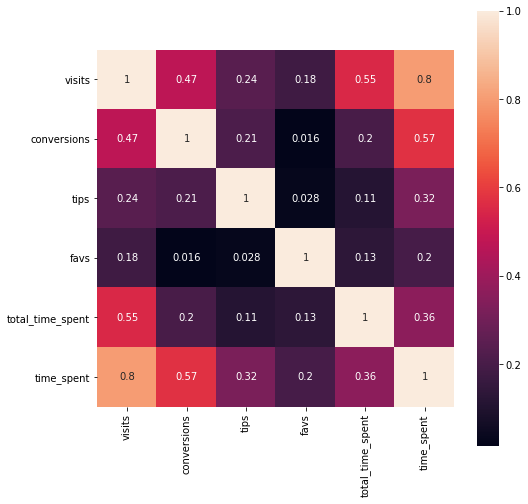

In [42]:
# корреляционная матрица признаков
corr_m = features.corr()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_m, square = True, annot = True,  ax=ax);

Высокая корреляция между признаками число сессий и проведеное время, что вполне логично и объяснимо.

На всех графиках наблюдаем длиннющие "хвосты", которые надо "резать к чёртовой матери"! Это дополнительно подтверждается значениями перцентилей. За границу достоверных значений возьмем 10 для числа сессий и числа целевых действий, 120 - суммарное время, проведенное в приложении, 25000 - время пользования приложением.

In [43]:
features_corrected = features.query('time_spent<120 and conversions<10 and visits<12 and total_time_spent<25000')
features_corrected.describe()

,visits,conversions,tips,favs,total_time_spent,time_spent
count,3942.000000,3942.000000,3942.000000,3942.000000,3942.000000,3942.000000
mean,2.188990,0.508879,0.142060,0.238965,2482.496880,19.566354
std,1.591831,1.342906,0.772275,1.330158,5124.656391,20.848945
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,8.833333,5.187500
50%,2.000000,0.000000,0.000000,0.000000,32.141667,12.283333
75%,3.000000,0.000000,0.000000,0.000000,1750.150000,26.600000
max,11.000000,9.000000,18.000000,28.000000,24968.583333,118.966667


In [44]:
features['conversions'].sum()

4529.0

In [45]:
features_corrected['conversions'].sum()

2006.0

Откинули всего 350 строк - 8% всей таблицы. Но эти 8% содержали больше половины конверсий! Видимо, резать хвосты было плохой идеей. Получается, что так мы выкидываем из анализа самую активную часть пользователей.

### Стандартизация данных

In [47]:
# предварительно откидываем столбец с id пользователей
X = features.drop(['user_id', 'conversions'], axis=1)
X.head()

,visits,tips,favs,total_time_spent,time_spent
0,5,0.0,0.0,21471.100000,43.816667
1,10,0.0,2.0,21337.583333,177.666667
2,2,0.0,0.0,24.700000,21.233333
3,7,0.0,0.0,18688.166667,87.550000
4,3,0.0,0.0,4892.516667,9.316667


In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4293 entries, 0 to 4292
Data columns (total 5 columns):
visits              4293 non-null int64
tips                4293 non-null float64
favs                4293 non-null float64
total_time_spent    4293 non-null float64
time_spent          4293 non-null float64
dtypes: float64(4), int64(1)
memory usage: 201.2 KB


In [49]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

## Выделение групп пользователей

### Построение матрицы расстояний на стандартизованной матрице признаков

In [50]:
linked = linkage(X_sc, method = 'ward')

### Построение дендрограммы

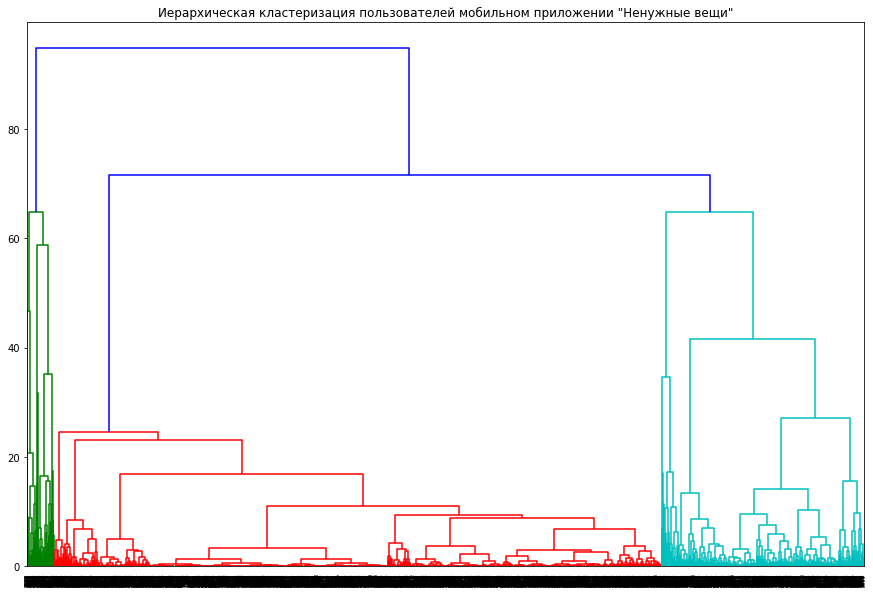

In [51]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей мобильном приложении "Ненужные вещи"')
plt.show()

### Определение числа кластеров на основе дендрограммы

#### Предложенное оптимальное число кластеров - 3

### Выбор и обучение модели кластеризации, прогнозирование кластеров клиентов

In [52]:
# задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters=3, random_state = 0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc) 

# сохраняем метки кластера в поле нашего датасета
features['cluster_km'] = labels
features.head()

,user_id,visits,conversions,tips,favs,total_time_spent,time_spent,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,5,0.0,0.0,0.0,21471.100000,43.816667,1
1,00157779-810c-4498-9e05-a1e9e3cedf93,10,11.0,0.0,2.0,21337.583333,177.666667,1
2,00463033-5717-4bf1-91b4-09183923b9df,2,0.0,0.0,0.0,24.700000,21.233333,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,7,0.0,0.0,0.0,18688.166667,87.550000,1
4,00551e79-152e-4441-9cf7-565d7eb04090,3,3.0,0.0,0.0,4892.516667,9.316667,0


### Анализ средних значений признаков для кластеров

In [53]:
# количество клиентов по кластерам
lusters_value = features.groupby('cluster_km', as_index=False).count()[['cluster_km', 'user_id']].rename(columns={'user_id': 'clusters_value'})
clusters_value['share'] = (clusters_value['clusters_value'] / 4293) * 100
clusters_value

,cluster_km,clusters_value,share
0,0,3649,84.998835
1,1,603,14.046122
2,2,41,0.955043


In [54]:
clusters_mean = features.groupby('cluster_km').mean()
clusters_mean

,visits,conversions,tips,favs,total_time_spent,time_spent
cluster_km,,,,,,
0,1.950397,0.682653,0.102220,0.175116,1139.067891,19.104316
1,6.850746,1.902156,0.475954,0.815920,18637.339856,61.862797
2,28.878049,21.731707,3.756098,6.975610,21809.395935,407.485772


Массив пользователей разбился на 3 очень неравных кластеров. 
- 85% пользователей попали в одну группу, в которой у пользователей 2 визита за исследуемый месяц, проведено в приложении около 19 минут, общее время использования (от самого первого действия в приложении до самого последнего) - около 19 часов, они не сохраняют объявления на будущее (какое же будущее за 19 часов использования?), не просматривают рекомендации. При этом 68% из них все-таки совершили целевое действие. То есть эти пользователи установили приложение, попробовали его использовать, две трети даже нашли для себя какое-то интересное объявление, но дальше что-то пошло не так. То ли им не понравилось само приложение, то ли общение с продавцом оставило неприятные эмоции;

- 14% использует приложение гораздо активнее  - у них совершено почти по 7 сессий, провели в приложении больше часа чистого времени, используют приложение почти 2 недели. конверсия втрое выше, чем у первой группы - 2 перехода в целевое действие;

- остался 1%, но это 1% каких-то суперменов. Максимальные показатели по всем признакам - почти 7 часов чистого времени в приложении, больше 2х недель использования, активное использование функций приложения. больше 20 целевых действий! Они просто живут в приложении!

### Анализ распределения признаков по кластерам

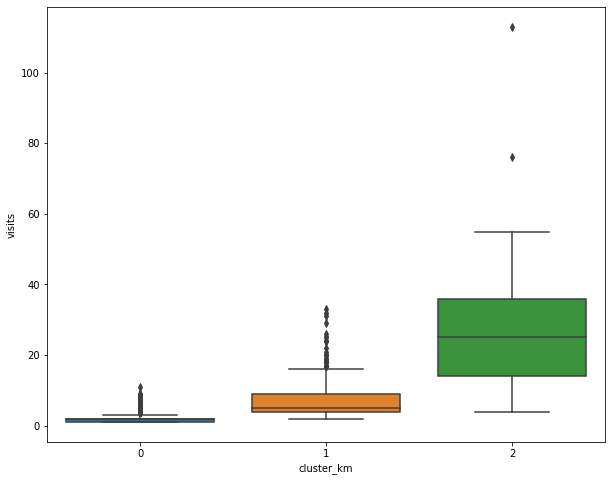

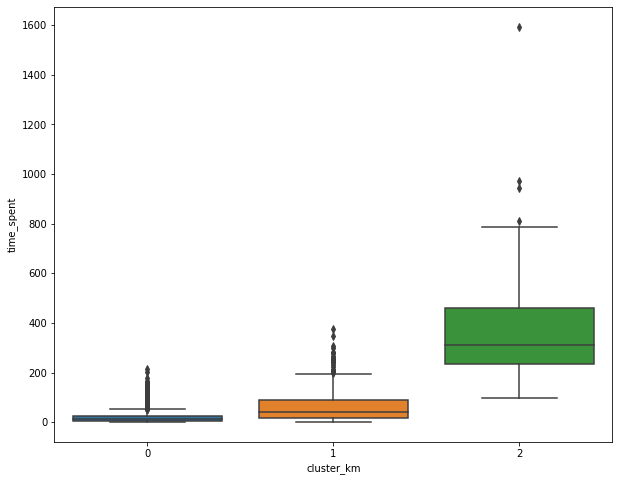

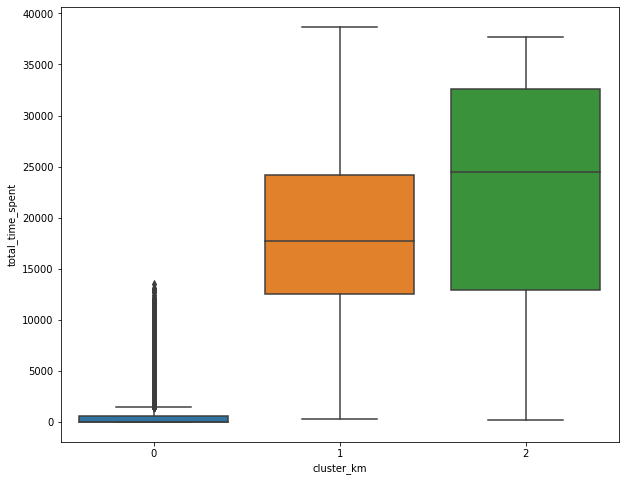

In [55]:
for column in {'visits', 'total_time_spent', 'time_spent'}:
    rcParams['figure.figsize'] = 10, 8
    sns.boxplot(x='cluster_km', y=column,  data=features)
    plt.show()

Графики подтверждают выводы, которые мы делали на основе таблицы со средними значениями признаков. Кластер №0 проседает по всем показателям, они явно не заинтересованы нашим приложением, надо что-то менять. Кластер №2 - красавчики и идеальные клиенты, побольше бы таких. Кластер 1 - что-то среднее.

### Анализ распределения целевой переменной по кластерам

In [56]:
clusters_mean['conversions']

cluster_km
0     0.682653
1     1.902156
2    21.731707
Name: conversions, dtype: float64

61% просмотров контактов делает кластер 0, несмотря на то, что их всего 6% от всех пользователей. Потом кластер 0, который делает 26% (при том, что пользователей там в 12 раз больше), и на 3м кластер 2 со скромными 12%.

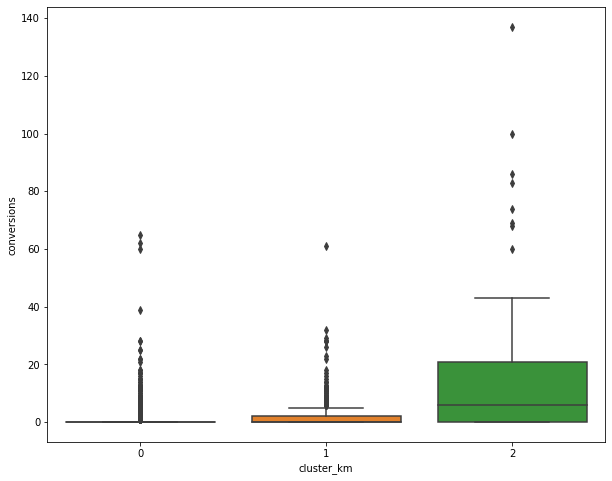

In [57]:
rcParams['figure.figsize'] = 10, 8
sns.boxplot(x='cluster_km', y='conversions',  data=features)
plt.show()

## Подведение итогов и представление результатов

### Формулировка выводов о поведении пользователей из разных групп

85% пользователей образовали кластер, в котором у них по 2 визита за исследуемый месяц, проведено в приложении около 19 минут, общее время использования (от самого первого действия в приложении до самого последнего) - около 19 часов, они не сохраняют объявления на будущее, не просматривают рекомендации. За счет того, что кластер очень большой, они в сумме дали 55% случаев целевого события, но для такого их числа это мало. Похоже, что это люди, которые установили себе приложение, но не нашли там  для себя интересного или оно им не понравилось и они его удалили. Очень плохо, что их так много. 

14% использует приложение гораздо активнее  - у них совершено почти по 7 сессий, провели в приложении больше часа чистого времени, используют приложение почти 2 недели. конверсия втрое выше, чем у первой группы - 2 перехода в целевое действие. Итого - 25% конверсии.

Самый маленький кластер (всего 1%) является и самым активным - почти 7 часов чистого времени в приложении, больше 2х недель использования, активное использование функций приложения. больше 20 целевых действий. Всего 1% пользователей обеспечил 20% конверсии. Таких пользователей нужно беречь, удерживать и всячески преумножать.

# Ссылка на дашборд в Tableau 

https://public.tableau.com/profile/vsevolod.sukhov#!/vizhome/sukhov_9A_mobil_app/Dashboard1

## Проверка статистических гипотез

### Проверьте гипотезу различия конверсии в просмотры контактов между теми пользователями, которые совершили установку приложения, прийдя с источника yandex и пользователя, совершившими установки, из источника google

In [58]:
# Всего пользователей по источникам 
total_users = users.groupby('source', as_index=False).count().rename(columns={'user_id':'total_users'})
total_users

,source,total_users
0,google,1129
1,other,1230
2,yandex,1934


In [59]:
# пользователи, совершившие целевое действие
goal_users = users_events.query('event_name=="contacts_show"').groupby(['source'], as_index=False).agg({'user_id':'nunique'}).rename(columns={'user_id':'goal_users'})
goal_users

,source,goal_users
0,google,275
1,other,228
2,yandex,478


In [60]:
conversion_users = pd.merge(goal_users, total_users, on='source').drop([1])
conversion_users

,source,goal_users,total_users
0,google,275,1129
2,yandex,478,1934


In [61]:
# считаем conversion rate
conversion_users['cr'] = conversion_users['goal_users'] / conversion_users['total_users']
conversion_users

,source,goal_users,total_users,cr
0,google,275,1129,0.243578
2,yandex,478,1934,0.247156


На первый взгляд конверсия очень-очень близка, отличие в долях процента. Но не будем полагаться на первый взгляд, обопремся на статистику.

Для проверки гипотезы различия конверсии у пользователей из разных источников используем z-критерий. 

За нулеваую гипотезу примем предположение, что доли для пользователей из разных источников равны. В этом случае разница между ними была бы равна нулю и, соответственно, z-критерий был бы равен нулю, а p_value = 1. Если p_value > альфа(0,05), считаем, что доли статистически не различаются. Посчитаем, как на самом деле.

In [62]:
alpha = .05 # критический уровень статистической значимости

purchases = np.array([275, 478])
leads = np.array([1129, 1934])

p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
distr = stats.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('z_value =', z_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

z_value = -0.2218487822311678
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Что ж, первый порывв всегда самый правильный, различий в конверсии в просмотры контактов между теми пользователями, которые совершили установку приложения, прийдя с источника yandex и пользователя, совершившими установки, из источника google действительно нет.